# Calculating weather regimes: a recipe

This recipe requires:
  - A Python environment on any operative system
  - `pandas`, `numpy`, `scikit-learn`
  - `xarray`, `cfgrib` (if the data is in GRIB format), `dask`, `netcdf4`
  - `eofs`
  - Climate data in Grib or NetCDF format

## Climate data
I have shared a dataset with daily 500 hPa geopotential height from ERA5 [on a Zenodo repository](https://zenodo.org/record/8384348). 

# The recipe

### 1. Importing modules

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### 2. Loading the data
The data is loaded from the specified path in a lazy way using `xarray` and `dask`

In [32]:
PATH = "YOUR/PATH/TO/DATA" # This is my path, please change it! 

# The chunks options *should* improve the performance in opening the files
df = (
    xr.open_mfdataset(f"{PATH}z500-2deg*nc", 
                       chunks={'longitude':31, 
                               'latitude': 16,
                               'time': -1})
    .convert_calendar('noleap')
)

### 3. Naming your experiment

In [33]:
LABEL = "1979_2022_ALL"

### 4. Subsetting data
If you want to compute the clusters only on some months or years. If you have multiple condition in `where` don't forget to add the boolean and `&`. 

In [53]:
df = (df
      .where(
          df.time.dt.year > 1978, # &
          # df.time.dt.month.isin([12, 1, 2]),
          drop = True)   
     )


### 5. Define a function to calculate the anomaly

In [54]:
def calculate_anomaly(da, groupby_type="time.dayofyear"):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

### 6. Calculate the anomaly
Using the function defined in the step 5 applying [`map_blocks`](https://docs.xarray.dev/en/stable/generated/xarray.map_blocks.html)

In [55]:
df_anom = df.map_blocks(calculate_anomaly, template=df.load()) 

### 7. Fixing the date time index
As explained by [this post on StackOverflow](https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime/55787899#55787899
)

In [56]:
df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
df_anom

C:\Users\matte\AppData\Local\Temp\ipykernel_18880\2841684129.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:        (time: 16060, latitude: 31, longitude: 61)
Coordinates:
    number         (time) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    step           (time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    isobaricInhPa  (time) float64 500.0 500.0 500.0 500.0 ... 500.0 500.0 500.0
  * latitude       (latitude) float64 80.0 78.0 76.0 74.0 ... 24.0 22.0 20.0
  * longitude      (longitude) float64 -90.0 -88.0 -86.0 ... 26.0 28.0 30.0
  * time           (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
    dayofyear      (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    z              (time, latitude, longitude) float32 1.797e+03 ... -277.9

### 8. Defining EOF and clustering parameters
The most important parameters are the number of EOFs to use as K-Means predictors (`n_eofs_for_kmeans`) and how many clusters (`n_clusters`)

In [57]:
use_scaling = 0
n_eofs = 30
n_eofs_for_kmeans = 20
n_clusters = 4

### 9. Setting up the EOF
Applying a square-root of cosine of latitude weighting (as shown [in this example](https://ajdawson.github.io/eofs/latest/examples/elnino_xarray.html?highlight=coslat))

In [58]:
coslat = np.cos(np.deg2rad(df_anom.coords['latitude'].values)).clip(0., 1.)
wgts   = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(df_anom['z'], weights=wgts)
eofs = solver.eofs(neofs=n_eofs)

### 10. Calculating the EOF
Also saving the explained variance

In [59]:
eofs_corr = solver.eofsAsCorrelation(neofs=n_eofs)
explained_var = solver.varianceFraction()

### 11. Extracting the principal components
Removing also some unneeded coordinates

In [60]:
pcs = solver.projectField(df_anom['z']
                          .drop(['dayofyear', 'number', 'step', 'isobaricInhPa']), 
                          neofs=n_eofs, 
                          eofscaling=use_scaling)

### 12. Converting the principal components to a data frame

In [61]:
df_pcs = (pcs
          .to_dataframe()
          .reset_index()
          .pivot(index='time', columns='mode',values='pseudo_pcs')
          .add_prefix('EOF')
         )
df_pcs.index = pd.to_datetime(df_pcs.index)
df_pcs.head()

mode,EOF0,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9,...,EOF20,EOF21,EOF22,EOF23,EOF24,EOF25,EOF26,EOF27,EOF28,EOF29
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,-17048.617188,15483.359375,4885.800781,-10292.749023,12818.223633,-10775.068359,-12156.664062,-318.342804,5868.339844,-4049.123779,...,2695.503418,490.255524,-4106.659180,866.225037,-1879.247314,-1899.829346,1736.193848,2545.238037,1488.298096,960.186401
1979-01-02,-15223.865234,9299.092773,9051.635742,1532.009766,15230.723633,-3107.334229,-16629.585938,9904.454102,10440.546875,2131.622070,...,5546.387207,2411.032227,-3312.291260,2791.641113,-2217.404785,-3191.788574,1162.769165,1242.997803,-1199.107788,1598.387451
1979-01-03,-15550.054688,8805.318359,13869.194336,17512.255859,21129.076172,8341.567383,-12048.231445,13787.189453,14018.848633,3852.889893,...,2615.435547,-768.914917,-3121.117676,-1257.992432,-638.627136,-431.068390,1040.877441,-1259.322388,-2918.790527,3560.449951
1979-01-04,-10905.307617,-3599.008789,21273.892578,29192.951172,16618.185547,1991.348877,-3895.130615,-2893.480713,8074.291504,3103.215820,...,1095.841309,-3314.329102,-3946.482178,873.703735,-2343.122314,2282.259033,-2088.127441,-2306.835205,348.632812,516.376770
1979-01-05,3648.596436,-10370.373047,22701.355469,18417.255859,6229.313965,-1756.549194,2720.189941,-6602.550293,3594.801025,7674.875000,...,2170.574463,-3611.327148,-2843.561279,980.506104,-738.846863,-527.405640,-1807.172119,-257.407471,-678.973145,2042.621094


### 13. Fit K-Means
This may take 20-30 seconds.

In [62]:
X_train = df_pcs.iloc[:, 0:n_eofs_for_kmeans].values
km = KMeans(n_clusters=n_clusters, n_init=500, verbose=0, tol=0.000001, max_iter=500, random_state=3)
km.fit(X_train)

KMeans(max_iter=500, n_clusters=4, n_init=500, random_state=3, tol=1e-06)

### 14. Creating a data frame with the labels

In [63]:
clus = pd.DataFrame(
    data=km.labels_, 
    columns=['cluster_id'], 
    index=df_pcs.index).reset_index()
clus.rename(columns={'time': 'date'}, inplace=True)

clus.set_index('date', inplace=True)

### 15. Calculating clusters' center

In [64]:
cluster_centers = pd.DataFrame(
    km.cluster_centers_, 
    columns=[f'eof{i}' for i in np.arange(1,n_eofs_for_kmeans+1)]
    )

### 16. Saving centers to data frame

In [65]:
cluster_center_array = xr.DataArray(
    cluster_centers.values, 
    coords=[np.arange(0, n_clusters), np.arange(0, n_eofs_for_kmeans) ], 
    dims=['centroids', 'mode'])

### 17. Computing the weighted cluster centers in the original space 


In [66]:
eigenvectors20 = eofs.loc[0:n_eofs_for_kmeans, ...]
recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

lons = recons_cluster_centers_weighted.coords['longitude'].values 
lats = recons_cluster_centers_weighted.coords['latitude'].values

coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)

weights_array = xr.DataArray(wgts, coords=[lats], dims=['latitude'])
recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array

### 18. Plot clusters


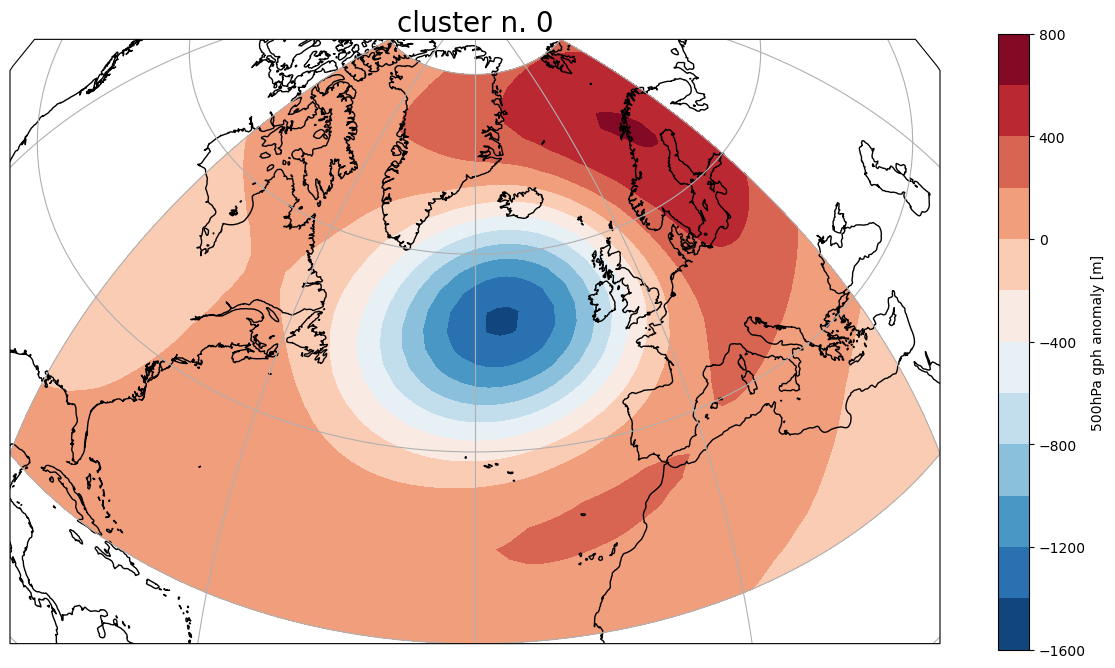

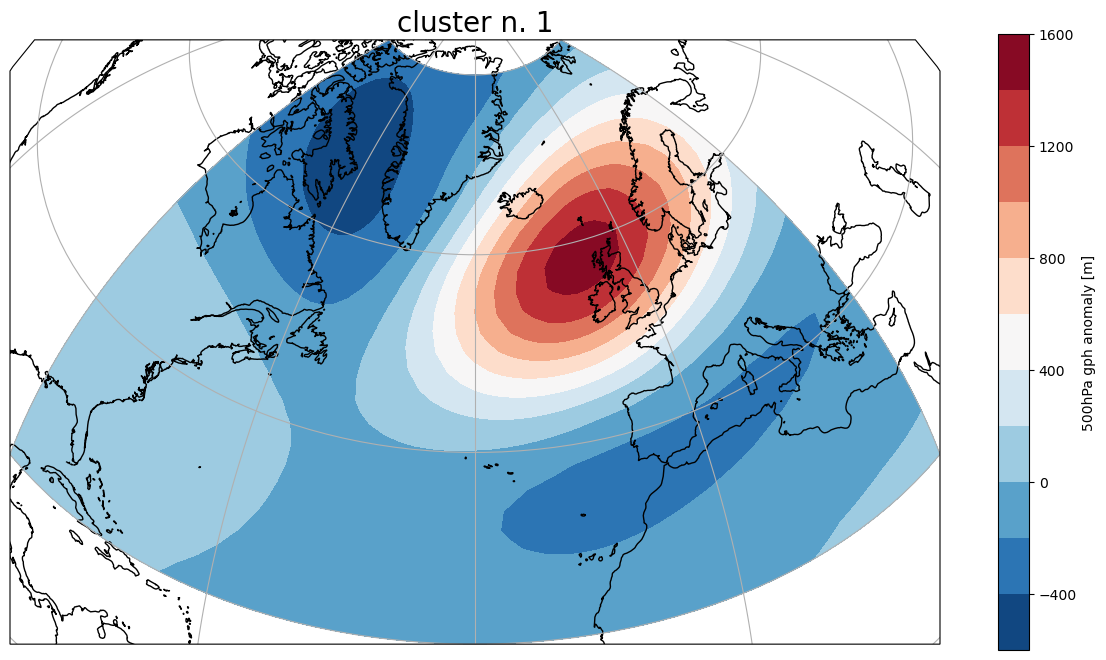

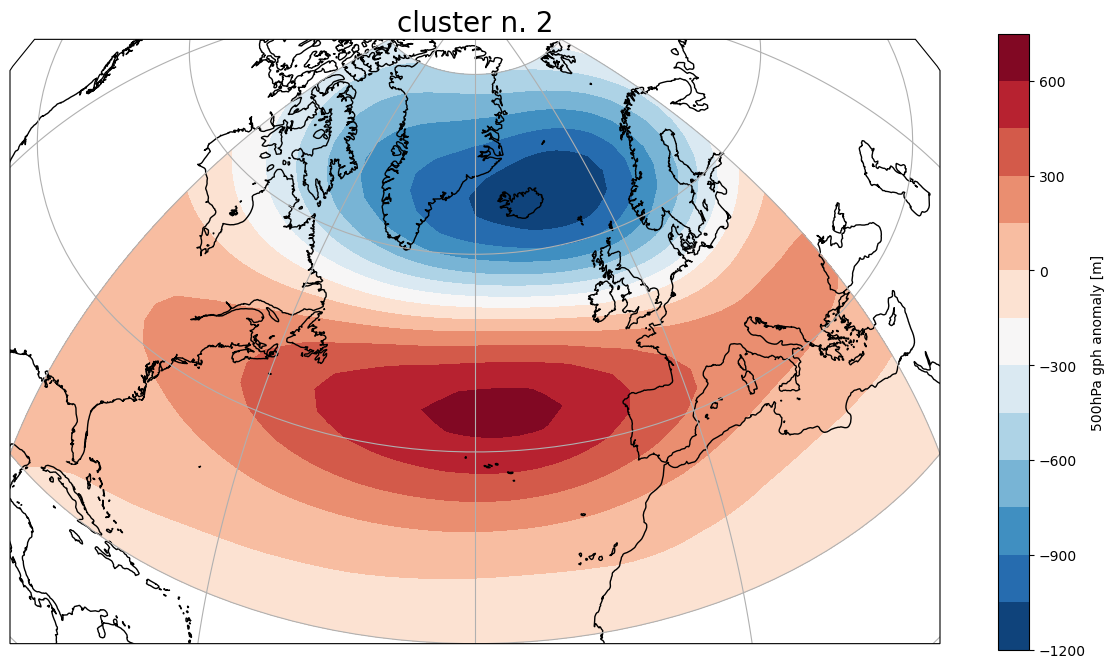

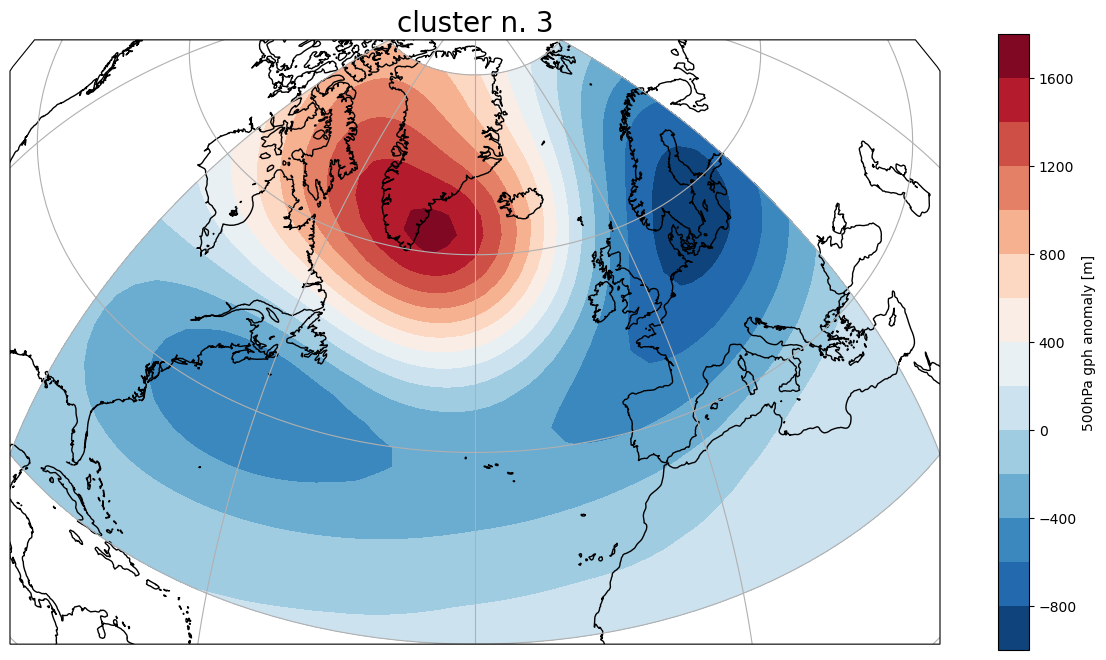

In [67]:
for i in np.arange(0, n_clusters):

    plt.figure(figsize=(15, 8))
    ax = plt.axes(
        projection=ccrs.Orthographic(central_longitude=-30, central_latitude=45))
    
    vals = recons_cluster_centers_unweighted[i, :, :].squeeze().values

    fill = ax.contourf(
        lons,
        lats,
        recons_cluster_centers_unweighted[i, :, :].squeeze(),
        levels=12,
        # norm=TwoSlopeNorm(
        #     vmin=np.nanmin(vals[~np.isinf(vals)]),
        #     vcenter=0,
        #     vmax=np.nanmax(vals[~np.isinf(vals)])),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree())

    cb = plt.colorbar(fill,
                      orientation='vertical',
                      label='500hPa gph anomaly [m]')
    # title = f'cluster center: {cluster_index_to_regi    me(i)}'
    title = f'cluster n. {i}'
    ax.coastlines(resolution='50m')
    ax.gridlines()
    
    plt.title(title, fontsize=20)
    plt.show()